<h1> Early Prediction </h1>

In [ ]:
from TCFile import TCFile

In [ ]:
import cv2
def sim_process(path, time, model, mini_model):
    
    file = TCFile(path, '2DMIP')
    crop_size = (160, 160)

    slice_2d = utils.resize_tomogram_mip(file[time], data_resolution=file.data_resolution,
                                                    target_resolution=0.1632, mode='mip')
                
    patches = utils.crop_patch(slice_2d, crop_size=crop_size)

    cropped_dict = {}
    for patch_index, patch in enumerate(patches):
        top = patch[0]
        left = patch[1]
        cropped = slice_2d[top:top+crop_size[0], left:left+crop_size[1]]
        cropped[cropped<1.33] = 1.33
        cropped[cropped>1.40] = 1.40
        cropped = utils.image_normalization(cropped, min=1.33, max=1.40)
        
        cropped_dict[f'patch_{patch_index}'] = cropped
    
    transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
    mini_transform = models.ResNet50_Weights.IMAGENET1K_V2.transforms()
    
    results = {}

    model = model.cuda()
    model.eval()
    
    mini_model = mini_model.cuda()
    mini_model.eval()
    with torch.no_grad():
        for patch in list(cropped_dict.keys()):
            image_array = cropped_dict[patch]
            
            temp = image_array.copy()
            temp[temp<45] = 0
            temp[temp>45] = 1
            proportion = np.count_nonzero(temp==1)/(np.count_nonzero(temp==0)+np.count_nonzero(temp==1))
            
            if proportion < 0.05:
                mini_temp = image_array.copy()
                mini_temp = cv2.equalizeHist(mini_temp)
                mini_temp = mini_transform(torch.from_numpy(mini_temp).repeat(3,1,1).float())
                mini_temp = mini_temp.cuda()
                is_necrosis = torch.max(mini_model(mini_temp.unsqueeze(0)), 1)[1].item()
                
                if is_necrosis==1:
                    image_tensor = torch.from_numpy(image_array).repeat(3,1,1).float()
                    image_tensor = transform(image_tensor)
                    image_tensor = image_tensor.cuda()
                        
                    output = model(image_tensor.unsqueeze(0))
                    output = output.cpu()
                    _, pred = torch.max(output, 1)
                    results[patch] = pred.item() + 1
                else:
                    results[patch] = 0
                # results[patch] = 0
            else:
                image_tensor = torch.from_numpy(image_array).repeat(3,1,1).float()
                image_tensor = transform(image_tensor)
                image_tensor = image_tensor.cuda()
                    
                output = model(image_tensor.unsqueeze(0))
                output = output.cpu()
                _, pred = torch.max(output, 1)
                results[patch] = pred.item() + 1
                
    return results

In [ ]:
from torchvision import models
import torch
import utils
import numpy as np

early = 20
reference = 32

path = r"C:\rkka_Projects\cell_death_v2\Data\Large_FOV\240808.200653.death_B4C4B5.005.Group3.B5.T001P01.TCF"
model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\test_5_classes_24.548490_0.9660.pth"
mini_model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\mini_ai_epoch_9_0.000861_1.0000.pth"
# Load Model
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 5)
)
model.load_state_dict(torch.load(model_path))

# Load mini Model
mini_model = models.resnet50(pretrained=True)
num_features = mini_model.fc.in_features
mini_model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 2)
)
mini_model.load_state_dict(torch.load(mini_model_path))


c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\김민욱\AppData\Local\Temp\ipykernel_11452\697372053.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY

<All keys matched successfully>

In [ ]:
early_results = sim_process(path, early, model, mini_model)

In [ ]:
reference_results = sim_process(path, reference, model, mini_model)

In [ ]:
def compute_similarity(early_results, reference_results):
    total_valid = 0
    matching = 0

    # Loop over each patch (assuming both dicts have the same keys)
    for patch in early_results:
        early_val = early_results[patch]
        ref_val = reference_results[patch]
        
        # Ignore this patch if either value is 0 (null)
        if early_val == 0 or ref_val == 0:
            continue

        total_valid += 1
        if early_val == ref_val:
            matching += 1

    # Avoid division by zero
    if total_valid == 0:
        return 0

    similarity_percentage = (matching / total_valid)
    return similarity_percentage

# Example usage:
similarity = compute_similarity(early_results, reference_results)
print(f"Similarity: {similarity:.2f}")


Similarity: 1.00


In [ ]:
def time_process(early_time, path, model):
    early = early_time
    reference = 32

    early_results = sim_process(path, early, model, mini_model)
    reference_results = sim_process(path, reference, model, mini_model)
    
    # Example usage:
    similarity = compute_similarity(early_results, reference_results)

    return similarity

In [ ]:
from tqdm import tqdm
import os

# get file list
root_dir = r"C:\rkka_Projects\cell_death_v2\Data\0_Apoptosis"
temp_list = os.listdir(root_dir)
path_list = [p for p in temp_list if p.endswith('.TCF')]

# Load Model
model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\test_5_classes_24.548490_0.9660.pth"
mini_model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\mini_ai_epoch_9_0.000861_1.0000.pth"
# Load Model
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 5)
)
model.load_state_dict(torch.load(model_path))

# Load mini Model
mini_model = models.resnet50(pretrained=True)
num_features = mini_model.fc.in_features
mini_model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 2)
)
mini_model.load_state_dict(torch.load(mini_model_path))

# Path by path
results = {}
for path in tqdm(path_list):
    # Time Prediction
    time_results = []
    for time in range(33):
        try:
            r = time_process(time, os.path.join(root_dir, path), model)
            time_results.append(r)
        except:
            continue
    results[os.path.basename(path)[:-4]] = time_results

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\김민욱\AppData\Local\Temp\ipykernel_17724\1509273948.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURIT

In [ ]:
import json

# Convert and write JSON object to file
mode = 'apoptosis'
with open(f"early_predictions/{mode}_prediction_results_1.json", "w") as outfile: 
    json.dump(results, outfile)
    outfile.close()

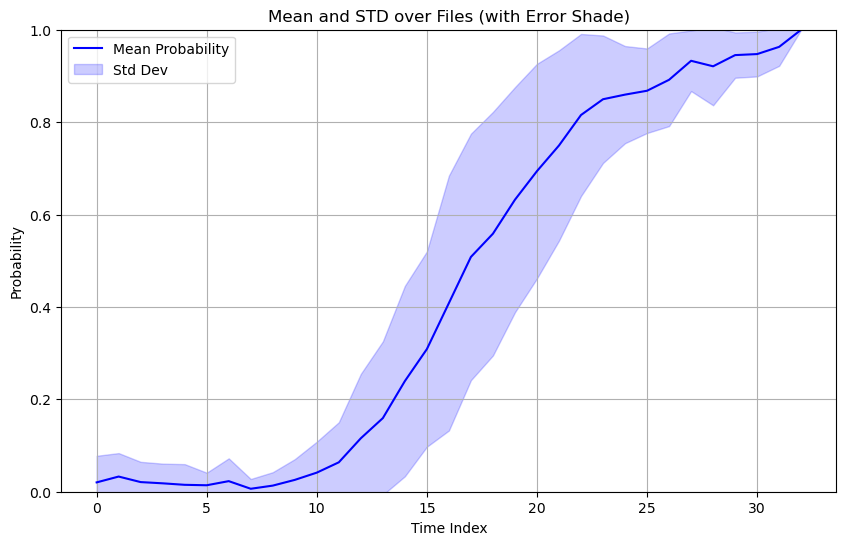

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

mode = 'apoptosis'
path = f"early_predictions/{mode}_prediction_results_1.json"
with open(path, "r") as f:
    data = json.load(f)

# Convert the data into a numpy array (shape: n_files x n_timepoints)
files = list(data.keys())
arr = np.array([data[k] for k in files])

# Compute element-wise mean and std over the files
mean_time = np.mean(arr, axis=0)
std_time = np.std(arr, axis=0)
time = np.arange(len(mean_time))

# Plot the mean as a line and the std as a shaded error region
plt.figure(figsize=(10, 6))
plt.plot(time, mean_time, 'b-', label='Mean Probability')
plt.fill_between(time, mean_time - std_time, mean_time + std_time, color='blue', alpha=0.2, label='Std Dev')
plt.xlabel('Time Index')
plt.ylabel('Probability')
plt.title('Mean and STD over Files (with Error Shade)')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

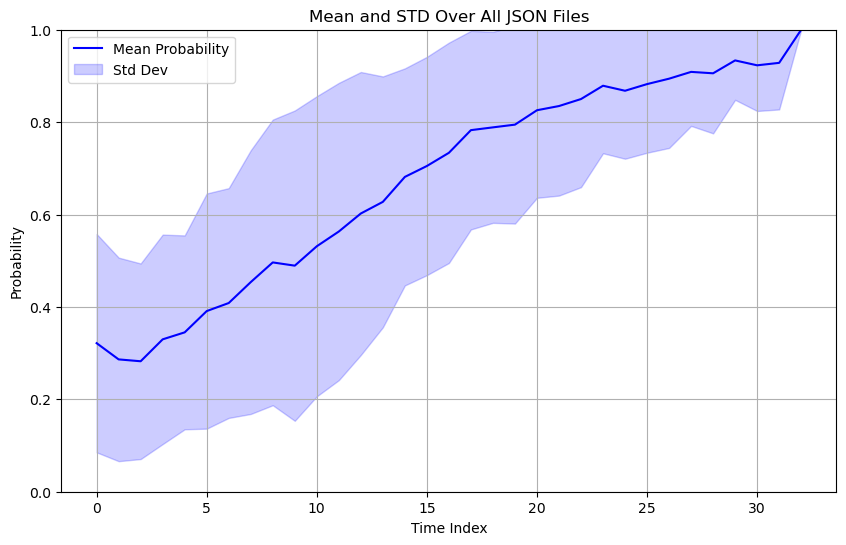

In [ ]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# Path to your folder containing the JSON files
folder_path = 'early_predictions'  # change this to your folder path
json_files = glob.glob(os.path.join(folder_path, '*.json'))

all_arrays = []
for file in json_files:
    with open(file, 'r') as f:
        data = json.load(f)
    # Loop over each key in the JSON file and collect its time-series
    for key in data:
        all_arrays.append(data[key])

# Convert list to numpy array: shape (total_series, timepoints)
arr = np.array(all_arrays)

# Compute the mean and standard deviation across all series for each time point
mean_time = np.mean(arr, axis=0)
std_time = np.std(arr, axis=0)
time = np.arange(len(mean_time))

# Plot the mean as a line with shaded error region for std
plt.figure(figsize=(10, 6))
plt.plot(time, mean_time, 'b-', label='Mean Probability')
plt.fill_between(time, mean_time - std_time, mean_time + std_time, color='blue', alpha=0.2, label='Std Dev')
plt.xlabel('Time Index')
plt.ylabel('Probability')
plt.title('Mean and STD Over All JSON Files')
plt.legend()
plt.grid(True)
plt.ylim(0,1)
plt.show()
